# DQN for Ms Pacman

**TLDR:** This notebook provides an implementation of a reinforcement learning agent using a deep q network to play Ms. Pac-Man.
<br>
<br>
$\rightarrow$ a detailed description is provided in [README.md](README.md) or [Project Documentation]()

## Table of Content

1. [Environment](#environment)
2. [Training](#train-agent)
3. [Evaluation](#evaluation)

## Imports

In [1]:
import collections
import time
import warnings

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.display import Video
from tqdm import tqdm

from src.DQN import DQN
from src.ReplayBuffer import ReplayBuffer
from src.utils import preprocess_state

# for windows
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# for mac
device = torch.device(
    "mps"
    if torch.backends.mps.is_available() and torch.backends.mps.is_built()
    else "cpu"
)

warnings.simplefilter("ignore")
np.random.seed(187)

## Environment

In [2]:
ENV_NAME = "ALE/MsPacman-v5"
env = gym.make(ENV_NAME, render_mode="rgb_array")

print("Observation Space: ", env.observation_space)
print("Action Space: ", env.action_space)
print("Actions: ", env.get_action_meanings())

Observation Space:  Box(0, 255, (210, 160, 3), uint8)
Action Space:  Discrete(9)
Actions:  ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


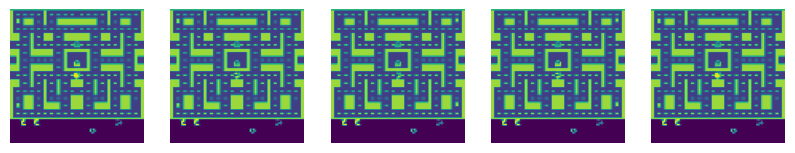

In [3]:
# plot sample states
obs, info = env.reset()

fig, axes = plt.subplots(figsize=(10, 10), nrows=1, ncols=5)
for i in range(5):
    obs, reward, done, trunc, info = env.step(env.action_space.sample())
    obs = preprocess_state(obs, stack_states=False, create_tensor=False)

    axes[i].imshow(obs)
    axes[i].axis("off")


env.close()

## Train Agent

### Set Parameter

In [4]:
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 1000
LEARNING_RATE = 1e-4
REPLAY_SIZE = 10000
BATCH_SIZE = 64
TARGET_UPDATE = 100
N_EPISODES = 1000
N_STACKED_FRAMES = 4
INPUT_SHAPE = (4, 84, 84)

# create experience tuple template
Experience = collections.namedtuple(
    "Exoeruebce", field_names=["state", "action", "reward", "done", "next_state"]
)

### Create Instances

In [5]:
env = gym.make(ENV_NAME, render_mode="rgb_array")

dqn = DQN(INPUT_SHAPE, env.action_space.n).to(device)
target_net = DQN(INPUT_SHAPE, env.action_space.n).to(device)
target_net.load_state_dict(dqn.state_dict())
target_net.eval()

optimizer = optim.Adam(dqn.parameters(), lr=LEARNING_RATE)
replay_buffer = ReplayBuffer(capacity=REPLAY_SIZE)

### Train Loop

In [6]:
epsilon = EPSILON_START
frame_idx = 0
episode_rewards = list()
episode_durations = list()

for episode in tqdm(range(1, N_EPISODES + 1), total=N_EPISODES, desc="Training"):
    start = time.time()
    state, info = env.reset()
    state = preprocess_state(
        state, stack_states=True, stack_size=N_STACKED_FRAMES, create_tensor=True
    ).to(device)

    done = False
    total_reward = 0
    while not done:

        frame_idx += 1

        # use epsilon greedy strategy to select action
        if np.random.rand() < epsilon:
            action = np.random.randint(env.action_space.n)
        else:
            action = dqn(state).argmax().item()

        # act in environment
        next_state, reward, done, _, info = env.step(action)
        # preprocess state
        next_state = preprocess_state(
            next_state,
            stack_states=True,
            stack_size=N_STACKED_FRAMES,
            create_tensor=True,
        ).to(device)
        total_reward += reward

        # store information in replay buffer
        exp = Experience(state, action, reward, done, next_state)
        replay_buffer.push(exp)
        state = next_state

        # restore experiences from replay buffer
        if replay_buffer.size > BATCH_SIZE:
            (
                sample_states,
                sample_actions,
                sample_rewards,
                sample_dones,
                sample_next_states,
            ) = replay_buffer.sample(BATCH_SIZE)

            # format samples as tensors
            sample_states = torch.cat(sample_states).to(device)
            sample_actions = torch.LongTensor(sample_actions).to(device)
            sample_rewards = torch.FloatTensor(sample_rewards).to(device)
            sample_next_states = torch.cat(sample_next_states).to(device)
            sample_dones = torch.FloatTensor(sample_dones).to(device)

            # calculate q values
            q_curr_state = (
                dqn(sample_states).gather(1, sample_actions.unsqueeze(-1)).squeeze(1)
            )
            q_next_state = target_net(sample_next_states).max(dim=1)[0]
            expected_q = sample_rewards + GAMMA * q_next_state * sample_dones

            # calculate loss
            loss = nn.MSELoss()(q_curr_state, expected_q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # update target network
        if frame_idx % TARGET_UPDATE == 0:
            target_net.load_state_dict(dqn.state_dict())

        # update epsilon
        epsilon = max(EPSILON_END, EPSILON_START - frame_idx / EPSILON_DECAY)

    episode_rewards.append(total_reward)
    episode_durations.append(time.time() - start)

env.close()

# save model
torch.save(dqn.state_dict(), "agent.pth")

Training: 100%|██████████| 1000/1000 [2:22:10<00:00,  8.53s/it] 


## Evaluation

In [ ]:
# create evaluation environment
eval_env = gym.make(ENV_NAME, render_mode="rgb_array")
# uncomment the following line to record a video for each episode
eval_env = gym.wrappers.RecordVideo(eval_env, "videos", episode_trigger=lambda x: True)

# uncomment the following line to load the model from saved file
# dqn = DQN(INPUT_SHAPE, eval_env.action_space.n).to(device)
# dqn.load_state_dict(torch.load("agent.pth"))
dqn.eval()

# evaluation loop
eval_episode_rewards = list()
eval_episode_durations = list()

for episode in tqdm(range(1, N_EPISODES), total=N_EPISODES, desc="Evaluation"):
    start = time.time()
    state, info = eval_env.reset()
    state = preprocess_state(
        state, stack_states=True, stack_size=N_STACKED_FRAMES, create_tensor=True
    ).to(device)

    done = False
    total_reward = 0
    while not done:
        # since we are evaluating the model, we use greedy strategy
        action = dqn(state).argmax().item()
        next_state, reward, done, _, info = eval_env.step(action)
        next_state = preprocess_state(
            next_state,
            stack_states=True,
            stack_size=N_STACKED_FRAMES,
            create_tensor=True,
        ).to(device)
        total_reward += reward
        state = next_state

    eval_episode_rewards.append(total_reward)
    eval_episode_durations.append(time.time() - start)

eval_env.close()

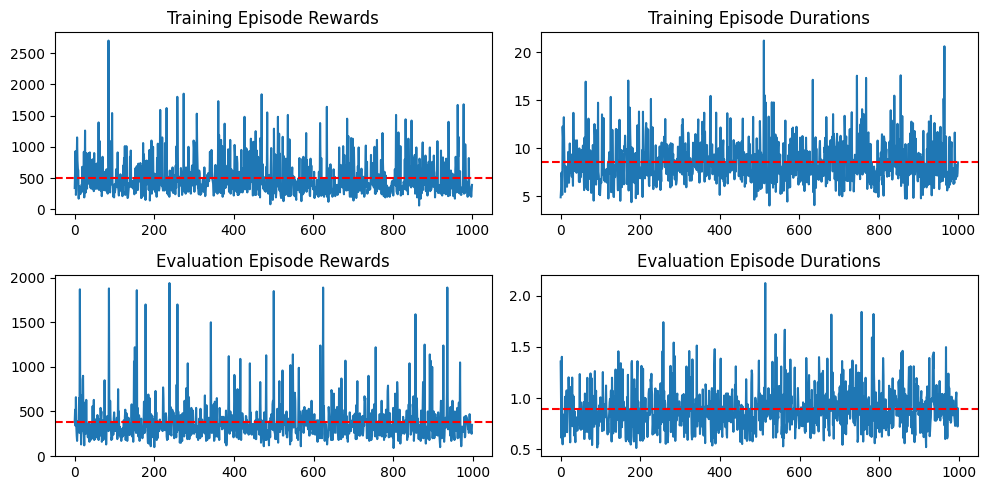

In [25]:
fig, axes = plt.subplots(figsize=(10, 5), nrows=2, ncols=2)
axes = axes.flatten()
axes[0].plot(episode_rewards)
axes[0].axhline(np.mean(episode_rewards), color="red", linestyle="--")
axes[0].set_title("Training Episode Rewards")

axes[1].plot(episode_durations)
axes[1].axhline(np.mean(episode_durations), color="red", linestyle="--")
axes[1].set_title("Training Episode Durations")

axes[2].plot(eval_episode_rewards)
axes[2].axhline(np.mean(eval_episode_rewards), color="red", linestyle="--")
axes[2].set_title("Evaluation Episode Rewards")

axes[3].plot(eval_episode_durations)
axes[3].axhline(np.mean(eval_episode_durations), color="red", linestyle="--")
axes[3].set_title("Evaluation Episode Durations")

fig.tight_layout()

In [31]:
print("Average Training Episode Reward: ", np.mean(episode_rewards))
print("Average Trian Episode Duration: ", np.mean(episode_durations), " seconds")
print()
print("Average Evaluation Episode Reward: ", round(np.mean(eval_episode_rewards), 2))
print(
    "Average Evaluation Episode Duration: ",
    round(np.mean(eval_episode_durations), 2),
    " seconds",
)

Average Training Episode Reward:  498.73
Average Trian Episode Duration:  8.530152093172074  seconds

Average Evaluation Episode Reward:  380.67
Average Evaluation Episode Duration:  0.89  seconds


### Display Episodes

In [34]:
print("First Episode Reward: ", episode_rewards[0])
Video("videos/rl-video-episode-0.mp4", width=400, height=400)

First Episode Reward:  340.0


In [33]:
print("Best Episode Reward: ", np.max(eval_episode_rewards))
Video(
    f"videos/rl-video-episode-{np.array(eval_episode_rewards).argmax()}.mp4",
    width=400,
    height=400,
)

Best Episode Reward:  1940.0


In [36]:
np.array(eval_episode_rewards).argmax()

238